# **IMPORT**

In [15]:
import pandas as pd
import warnings 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import wandb

import random 


from pathlib import Path

root_to_data = Path('/kaggle/input/AI4Code')

plt.style.use('ggplot')
warnings.simplefilter('ignore')
CONFIG = {'competition': 'AI4Code', '_wandb_kernel': 'aot'}

# **DATA**

<h3>train_ancestors</h3>
<ul>
    <li><b>id</b> - unique ID of the notebook (same as for train_orders.csv)</li>
    <li><b>ancestor_id</b> - notebook that has a common origin or ancestor (good as grouping factor when constructing validation splits)</li>
    <li><b>parent_id</b> - the original notebook, which may be present in the train data or not</li>
</ul>

In [2]:
train_ancestors_df = pd.read_csv(f'{root_to_data}/train_ancestors.csv')
print(train_ancestors_df.shape, '\n', train_ancestors_df.head(3))

(139256, 3) 
                id ancestor_id       parent_id
0  00001756c60be8    945aea18             NaN
1  00015c83e2717b    aa2da37e  317b65d12af9df
2  0001bdd4021779    a7711fde             NaN


<h3>train_orders.csv - TRAIN DATA</h3>
<ul>
    <li><b>id</b> - unique ID of the notebook</li>
    <li><b>cell_order</b> - gives the correct order of each cell within this notebook</li>
</ul>

In [3]:
train_orders_df = pd.read_csv(f'{root_to_data}/train_orders.csv')
print(train_orders_df.shape, '\n', train_orders_df.head(3))

(139256, 2) 
                id                                         cell_order
0  00001756c60be8  1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...
1  00015c83e2717b  2e94bd7a 3e99dee9 b5e286ea da4f7550 c417225b 5...
2  0001bdd4021779  3fdc37be 073782ca 8ea7263c 80543cd8 38310c80 0...


In [4]:
sample_submission_df = pd.read_csv(f'{root_to_data}/sample_submission.csv')
print(sample_submission_df.shape, '\n', sample_submission_df.head(3))

(4, 2) 
                id                                         cell_order
0  0009d135ece78d  ddfd239c c6cd22db 1372ae9b 90ed07ab 7f388a41 2...
1  0010483c12ba9b  54c7cab3 fe66203e 7844d5f8 5ce8863c 4a0777c4 4...
2  0010a919d60e4f  aafc3d23 80e077ec b190ebb4 ed415c3c 322850af c...


In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key") 

wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
# init new expirement in wandb 
run = wandb.init(project='AI4Code', name='metadata-explore', config=CONFIG)

wandb: Currently logged in as: knyazev_artem (ai-sigma). Use `wandb login --relogin` to force relogin


In [7]:
wandb.log({"unique_notebooks" : train_orders_df.id.nunique()})
print(f'orders.id.nunique: {train_orders_df.id.nunique()}')

orders.id.nunique: 139256


In [8]:
wandb.log({"unique_ancestors" : train_ancestors_df.ancestor_id.nunique()})
print(f'unique_ancestors: {train_ancestors_df.ancestor_id.nunique}')

unique_ancestors: <bound method IndexOpsMixin.nunique of 0         945aea18
1         aa2da37e
2         a7711fde
3         090152ca
4         272b483a
            ...   
139251    6aed207b
139252    a6aaa8d7
139253    0a1b5b65
139254    d971e960
139255    3c40bfa6
Name: ancestor_id, Length: 139256, dtype: object>


In [9]:
# Get frequency per ancestor_id
data = train_ancestors_df.groupby("ancestor_id")["id"].count().reset_index().\
                sort_values("id", ascending=False).reset_index(drop=True)
data.columns = ["ancestor_id", "count"]


# Basic metrics
total_singles = data[data["count"]==1].shape[0]
total_double_plus = data[data["count"]>1].shape[0]

print("Total number of ids with only 1 ancestor:", total_singles, "\n"+ "\t"*4+"percent:", round(total_singles/len(data), 3), "\n")
print("Total number of ids with 2+ ancestors:", total_double_plus, "\n"+ "\t"*4+"percent:", round(total_double_plus/len(data), 3))


Total number of ids with only 1 ancestor: 118529 
				percent: 0.945 

Total number of ids with 2+ ancestors: 6843 
				percent: 0.055


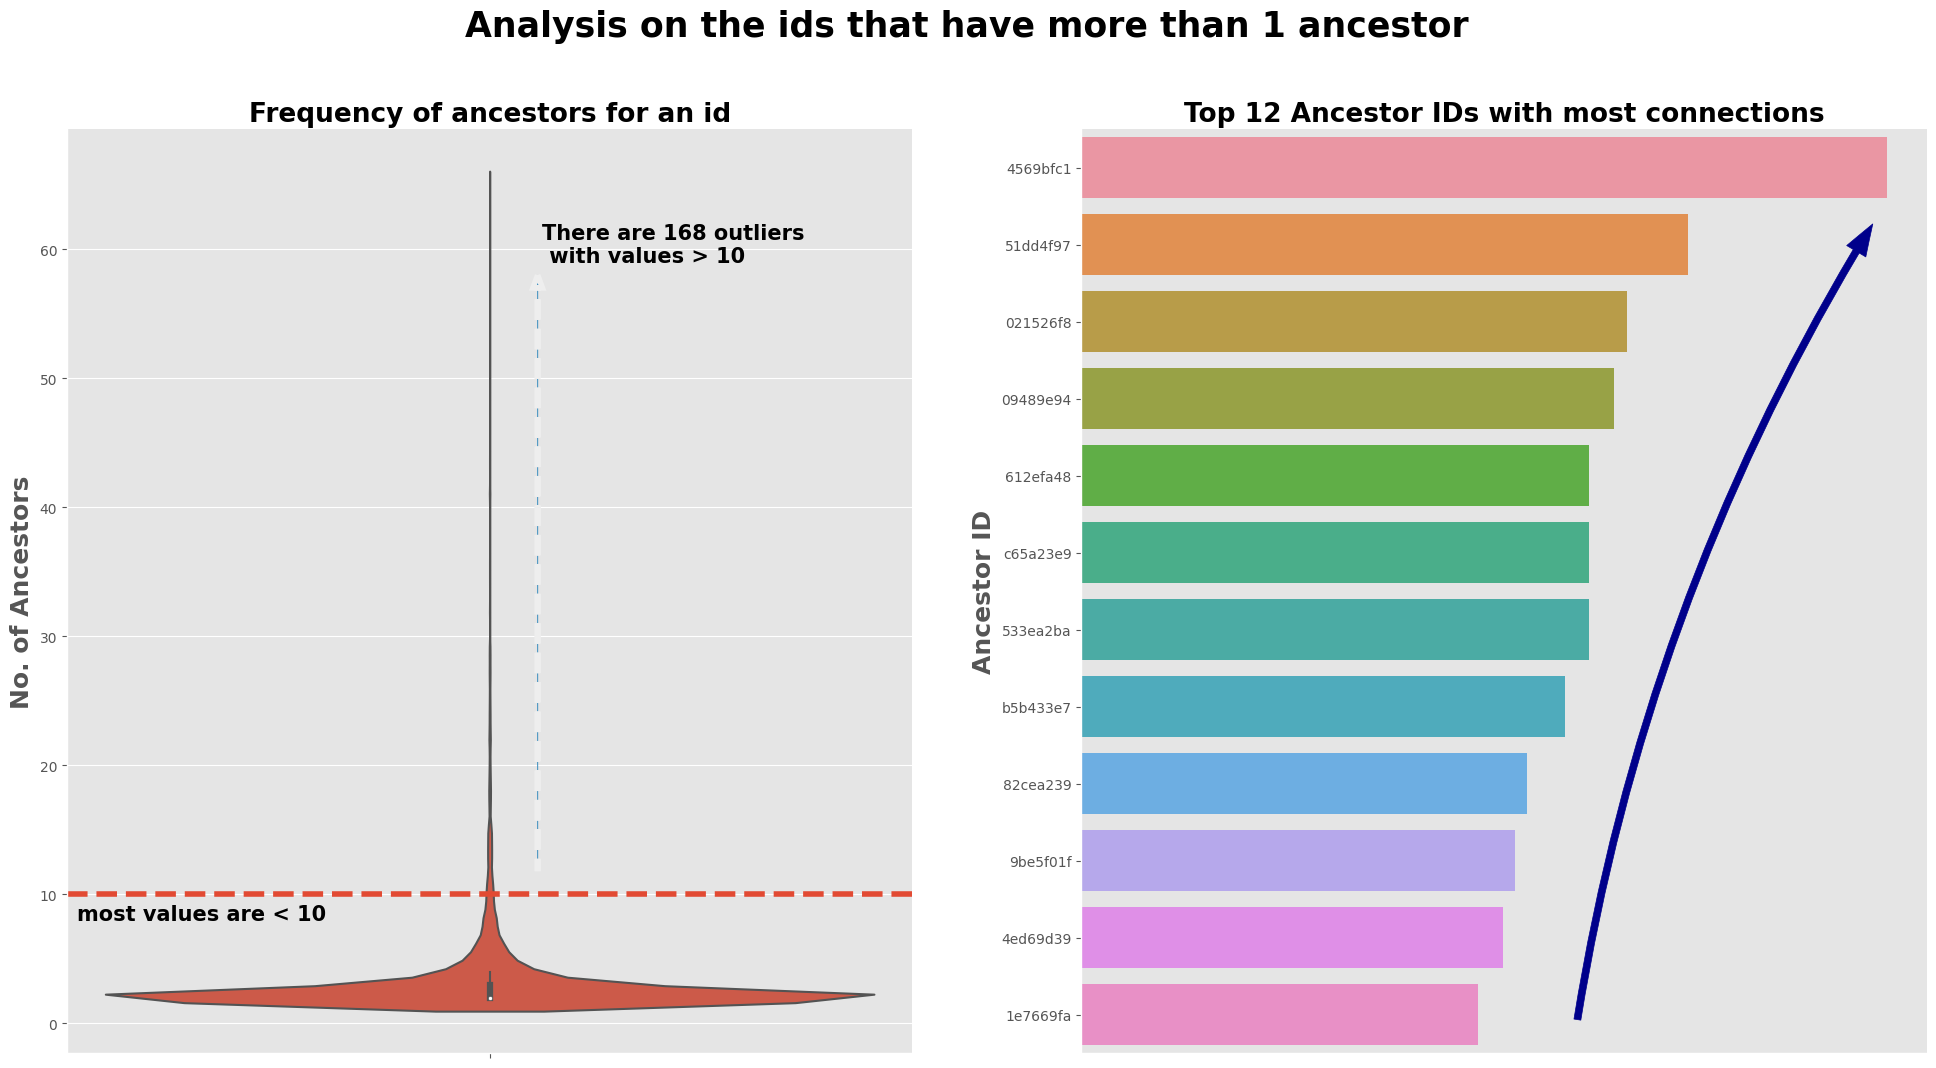

In [ ]:
# Let's make a plot about count ancestor_id by ids that have more than 1 ancestor 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Analysis on the ids that have more than 1 ancestor', 
             weight="bold", size=25)

# Violinplot
sns.violinplot(data=data[data["count"]>1], y="count", ax=ax1)
ax1.set_title("Frequency of ancestors for an id", weight="bold", size=19)
ax1.set_ylabel("No. of Ancestors", size = 18, weight="bold")
ax1.axhline(y=10, linestyle = '--', lw=4)
ax1.text(x=-0.43, y=8, s="most values are < 10", size=15, weight="bold")
ax1.arrow(x=0.05, y=12, dx=0, dy=45, lw=4, 
          head_width=0.01, head_length=1, linestyle = '--')
ax1.text(x=0.055, y=59, s="There are 168 outliers \n with values > 10", size=15, weight="bold")

# Barplot
sns.barplot(data=data[data["count"]>1].head(12), x="count", y="ancestor_id", ax=ax2)
#show_values_on_bars(axs=ax2, h_v="h", space=0.4)
ax2.set_title("Top 12 Ancestor IDs with most connections", weight="bold", size=19)
ax2.set_ylabel("Ancestor ID", size = 18, weight="bold")
ax2.set_xlabel("")
ax2.set_xticks([])

# Arrow
style = "Simple, tail_width=5, head_width=16, head_length=23"
kw = dict(arrowstyle=style, color='darkblue')
arrow = patches.FancyArrowPatch((40, 11.1), (64, 0.7),
                             connectionstyle="arc3,rad=-.10", **kw)
plt.gca().add_patch(arrow)

sns.despine(right=True, top=True);

In [ ]:
# top 12 ancestors IDs with most connections 
data[data['count'] > 1].head(12)

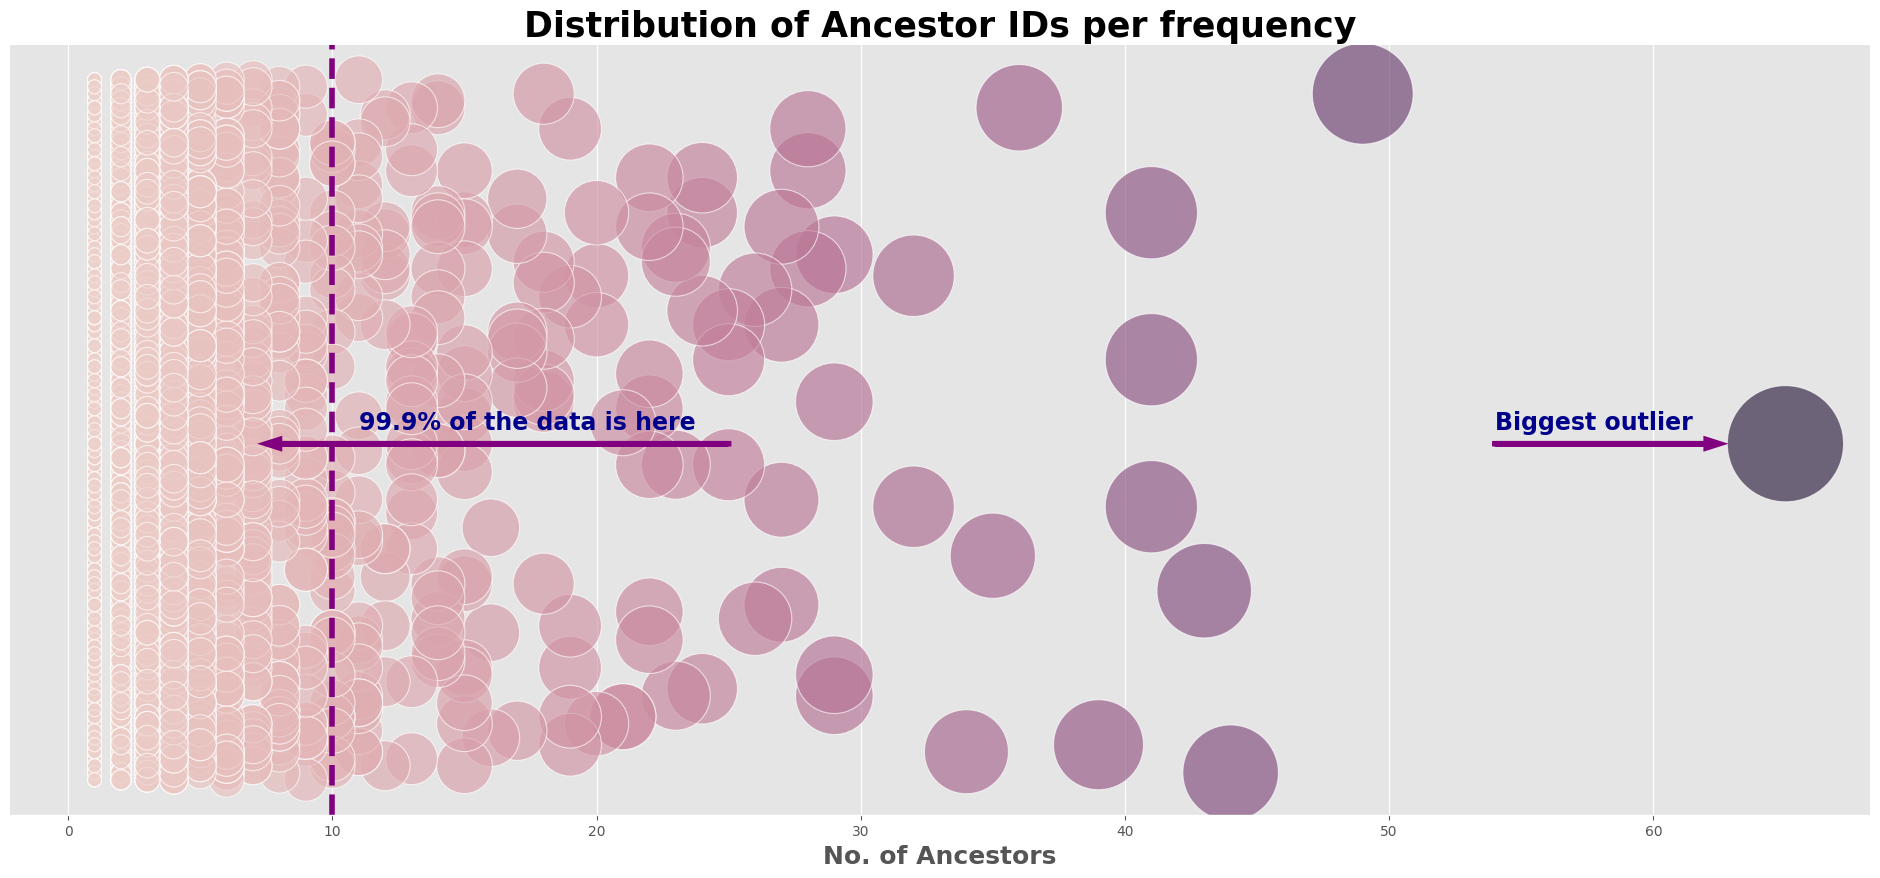

In [12]:
random.seed(25)

# this "y" doesn't mean anything, it's just for
# showcasing purposes
data["demonstration"] = [random.randint(0, 100) for i in range(len(data))]
perc = round(data[data["count"]<=10].shape[0]/len(data), 3)*100

plt.figure(figsize=(24, 10))
sns.scatterplot(data=data, x="count", y="demonstration", size="count", alpha=0.65, sizes=(100, 7000),
               hue="count")

plt.title("Distribution of Ancestor IDs per frequency", weight="bold", size=25)
plt.xlabel("No. of Ancestors", size = 18, weight="bold")
plt.ylabel("")
plt.yticks([])

plt.axvline(x=10, linestyle = '--', color="purple", lw=4)
plt.text(x=11, y=50, s=f"{perc}% of the data is here", color="darkblue", size=17, weight="bold")
plt.arrow(x=25, y=48, dx=-17, dy=0, color="purple", lw=4, 
          head_width=1.2, head_length=0.5)

plt.text(x=54, y=50, s=f"Biggest outlier", color='darkblue', size=17, weight="bold")
plt.arrow(x=54, y=48, dx=8, dy=0, color='purple', lw=4, 
          head_width=1.2, head_length=0.5)

plt.legend('',frameon=False)

sns.despine(right=True, top=True, left=True);

In [13]:
# finish experiment in wandb
wandb.finish()

unique_ancestors,▁
unique_notebooks,▁
unique_ancestors,125372
unique_notebooks,139256


# **Language Detection**

'2.2.2'